In [2]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import random
from geneticalgorithm import geneticalgorithm as ga


In [3]:
def toy_model(t, y, ydot, params):
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    T = 1; E = 2; X = 2
    A, W = params
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    for e in range(E):
        ydot[e+X] = -lam*y[e+X] + np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]]))
    ydot[E+X] = (Vin - y[X+1]*nonlinearity(y[X-1], kc, km))**2 #J1
    ydot[E+X+1] = np.sum([np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]])) for e in range(E)]) #J2

def arch_converter(A):
    if A == 1: #dual control
        return ((0, 1, 0), (1, 0, 0))

    elif A == 2: #no control
        return ((0, 0, 1), (0, 0, 1))

    elif A == 3: #downstream activation
        return ((0, 0, 1), (1, 0, 0))

    elif A == 4: #upstream repression
        return ((0, 1, 0), (0, 0, 1))
    else: return 'Invalid Circuit'

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)
    
def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

6335.472323558569 87.55933359999996 0.9389480592355853


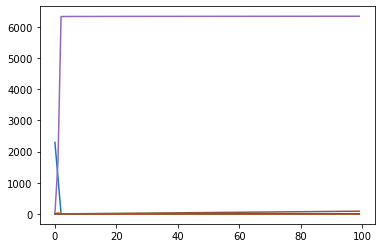

In [5]:
#Plot single solution
vars = [2.00000000e+00, 7.88726164e-04, 9.62460508e-04, 4.49906622e+00, 1.98400034e+00]
A, k1, k2, theta1, theta2 = vars

t = np.linspace(0, 5E4, 100) 
y0 = np.array([2290., 0., 0., 0., 0., 0.])

architecture = arch_converter(vars[0])
param_values = [[2., theta1, k1], [2., theta2, k2]]

extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
ode_solver = ode('cvode', toy_model, **extra_options)
solution = ode_solver.solve(t, y0)
j1, j2 = solution.values.y[-1, -2:]
j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
plt.plot(solution.values.y)
print(j1, j2, loss)

6335.472323558569 87.55933359999996 0.9389480592355853


,k1,k2,theta1,theta2,loss,j1,j2,sol_flag
0,0.000789,0.000962,4.499066,1.984,0.938948,87.559334,87.559334,StatusEnum.SUCCESS


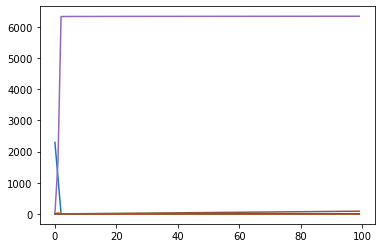

In [6]:
def f(X):
    A, k1, k2, theta1, theta2 = X
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = arch_converter(A)
    param_values = [[2., theta1, k1], [2., theta2, k2]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    row = [k1, k2, theta1, theta2, loss, j2, j2, str(solution.flag)]
    trace.loc[len(trace)] = row
    if (str(solution.flag) == 'StatusEnum.SUCCESS'): return solution
    else: return 1.E7

columns = ['k1', 'k2', 'theta1', 'theta2', 'loss', 'j1', 'j2', 'sol_flag']
trace = pd.DataFrame(columns=columns)
solution = f(vars)
j1, j2 = solution.values.y[-1, -2:]
j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
plt.plot(solution.values.y)
print(j1, j2, loss)
trace

In [8]:
def f(X):
    A, k1, k2, theta1, theta2 = X
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = arch_converter(A)
    param_values = [[2., theta1, k1], [2., theta2, k2]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-3}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    row = [A, k1, k2, theta1, theta2, loss, j2, j2, str(solution.flag)]
    trace.loc[len(trace)] = row
    if (str(solution.flag) == 'StatusEnum.SUCCESS') and loss > 0.0: return loss
    else: return 1.E7
    
varbound=np.array([[1,4],[1E-7,1E-3],[1E-7,1E-3], [1E-3, 10], [1E-3, 10]])
vartype=np.array([['int'], ['real'],['real'],['real'],['real']])

algorithm_param = {'max_num_iteration': None,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

columns = ['arch', 'k1', 'k2', 'theta1', 'theta2', 'loss', 'j1', 'j2', 'sol_flag']

 The best solution found:                                                                           
 [1.00000000e+00 5.43456077e-04 3.60949414e-05 2.80335713e+00
 9.83583691e+00]

 Objective function:
 0.04514357499707407


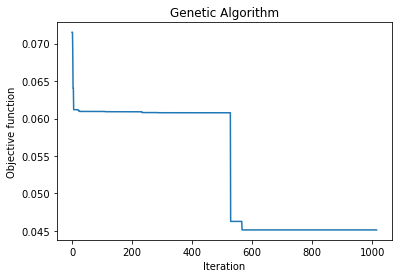

In [7]:
trace = pd.DataFrame(columns=columns)
model=ga(function=f,dimension=5,variable_type_mixed=vartype,variable_boundaries=varbound, algorithm_parameters=algorithm_param)

start_time = time.time()
model.run()
elapsed_time = time.time() - start_time
trace['Computational Time'] = elapsed_time
results = model.output_dict
trace.to_csv('ga_result_rep1.txt')

 The best solution found:                                                                           
 [3.00000000e+00 4.51270390e-05 3.48931677e-05 1.35731116e+00
 9.95583144e+00]

 Objective function:
 0.06078168726092886


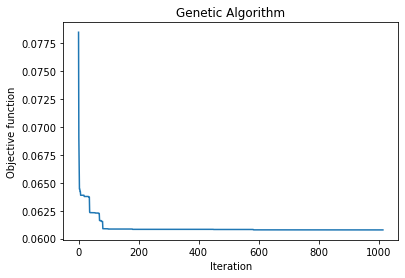

In [8]:
trace = pd.DataFrame(columns=columns)
model=ga(function=f,dimension=5,variable_type_mixed=vartype,variable_boundaries=varbound, algorithm_parameters=algorithm_param)

start_time = time.time()
model.run()
elapsed_time = time.time() - start_time
trace['Computational Time'] = elapsed_time
results = model.output_dict
trace.to_csv('ga_result_rep2.txt')

|||||||||||||||||||_______________________________ 37.2% GA is running...


[CVODE ERROR]  CVode
  At t = 6716.23 and h = 0.00107571, the error test failed repeatedly or with |h| = hmin.



 The best solution found:                                                                           
 [1.00000000e+00 4.67946171e-05 1.51472546e-04 4.14357089e+00
 9.03149297e+00]

 Objective function:
 0.05784536680108311


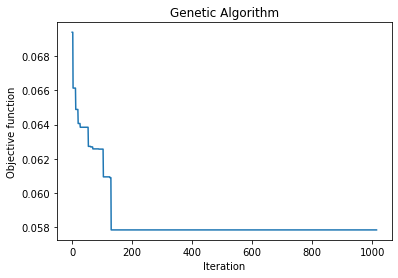

In [9]:
trace = pd.DataFrame(columns=columns)
model=ga(function=f,dimension=5,variable_type_mixed=vartype,variable_boundaries=varbound, algorithm_parameters=algorithm_param)

start_time = time.time()
model.run()
elapsed_time = time.time() - start_time
trace['Computational Time'] = elapsed_time
results = model.output_dict
trace.to_csv('ga_result_rep3.txt')